In [1]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

# Extracting Image Features 
This with initialize the VGG16 model and then creates a modified version that outputs features from its second-to-last layer.

In [3]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

Now let's iterates through a directory containing images, processes each image to fit the input requirements of a pretrained model (model), predicts features for each image using this model, and then stores these features in a dictionary (features) where each image's ID serves as the key. The tqdm function will be used to show a progress bar during the iteration through the images.

In [4]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')
for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

Now we will saves the `features` dictionary to a file named 'features.pkl' using pickle serialization in binary mode.

In [5]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

## Loading Captions Data

In [6]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

Let's iterates through lines in a document of captions (`captions_doc`), splits each line by commas to extract image IDs and their corresponding captions, formats the data for consistency, and stores multiple captions per image ID in a dictionary (`mapping`).

In [7]:
mapping = {}

for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [8]:
len(mapping)

8091

## Text Preprocessing

It iterates through each caption, converting it to lowercase, removing non-alphabetic characters, consolidating consecutive spaces, adding start and end sequence tokens for sequence generation tasks. The preprocessing ensures uniformity and prepares captions for tasks like image captioning by standardizing format and content.

In [9]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

Before preprocess of text

In [10]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

Preprocess the text

In [11]:
clean(mapping)

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

after preprocess of text


In [ ]:
mapping['1000268201_693b08cb0e']

By iterating through each key-value pair in mapping, the code gathers all captions into a single list (all_captions). This consolidation is useful for tasks that require all captions to be processed or analyzed collectively, such as text analysis, training language models, or preparing data for neural network training.

In [12]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [13]:
print(len(all_captions))
print()
print(all_captions[:10])

40455

['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq', 'startseq black dog and spotted dog are fighting endseq', 'startseq black dog and tri-colored dog playing with each other on the road endseq', 'startseq black dog and white dog with brown spots are staring at each other in the street endseq', 'startseq two dogs of different breeds looking at each other on the road endseq', 'startseq two dogs on pavement moving toward each other endseq']


This code uses a Tokenizer to convert a list of captions (all_captions) into numerical sequences for machine learning, while also determining the size of the vocabulary.

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [15]:
vocab_size

8485

Max Length

In [16]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

Train Test Split

In [17]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

Let's create a `data_generator` function that prepares batches of training data for a model learning to generate captions from images. This function loops through each image and its captions, converts text into sequences of numbers, and pairs these sequences with image features. By doing this dynamically and in batches, it ensures the model receives consistent data during training, making the learning process efficient and manageable in terms of memory and computation.

In [18]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0 
    while 1:       
        for key in data_keys:
            n += 1            
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

Model: This code defines a neural network architecture for image captioning:

- **Image Features**: Processes image features through dropout and a dense layer.
- **Sequence Features**: Embeds text sequences, applies dropout, and uses an LSTM to model sequential information.
- **Decoder**: Combines image and sequence features, then predicts word probabilities.
- **Model Compilation**: Sets up the model with inputs for images and text, compiling it with categorical cross-entropy loss and the Adam optimizer.
- **Visualization**: Generates a visual representation of the model's structure for clarity and debugging.

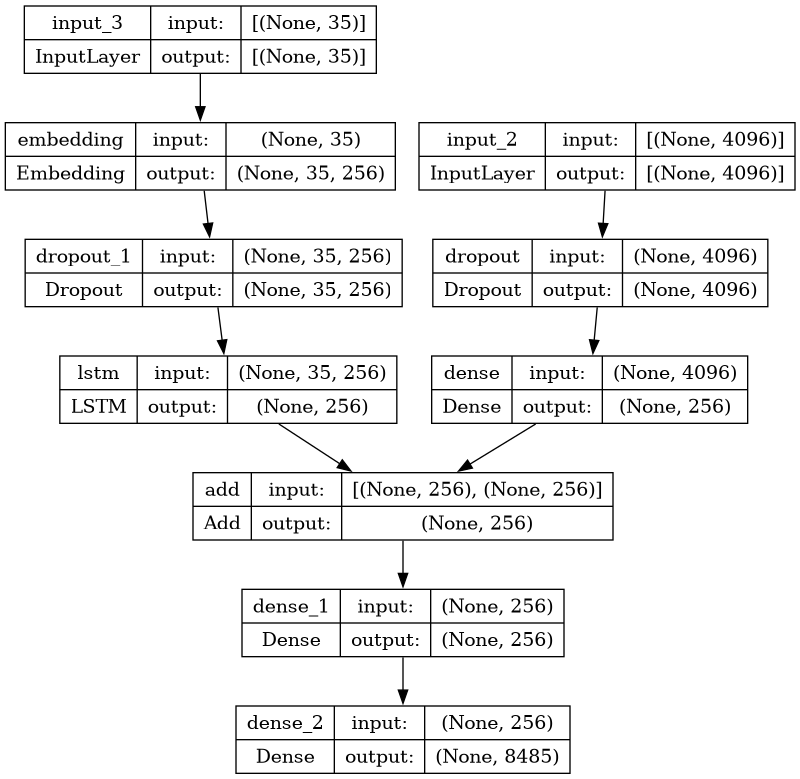

In [19]:
# Image feature layers:
inputs1 = Input(shape=(4096,)) # Input for image features (4096 dimensions)
fe1 = Dropout(0.2)(inputs1) # Apply dropout for regularization
fe2 = Dense(256, activation='elu')(fe1) # Dense layer with ReLU activation

# Sequence feature layers:
inputs2 = Input(shape=(max_length,)) # Input for text sequences
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2) # Word embedding layer
se2 = Dropout(0.2)(se1)
se3 = LSTM(256)(se2) # LSTM layer to model sequential information

# Decoder layers:-
decoder1 = add([fe2, se3]) # Combine image and sequence features
decoder2 = Dense(256, activation='elu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2) # Output layer with softmax for word probabilities

model = Model(inputs=[inputs1, inputs2], outputs=outputs) # Define model with two inputs and one output
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot the model
plot_model(model, show_shapes=True)

In [20]:
epochs = 50
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 42s 183ms/step - loss: 1.5162


Save the model

In [21]:
model.save(WORKING_DIR+'/img_caption_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Generate Captions for Image

In [22]:
def idx_to_word(integer, tokenizer):
    """
    Converts a numerical token ID back to its corresponding word using a tokenizer.

    Args:
        integer: The integer ID representing the word.
        tokenizer: The tokenizer object that was used to tokenize the text.

    Returns:
        The word corresponding to the integer ID, or None if the ID is not found.
    """

    # Iterate through the tokenizer's vocabulary
    for word, index in tokenizer.word_index.items():
        # If the integer ID matches the index of a word, return the word
        if index == integer:
            return word

    # If no matching word is found, return None
    return None

In [25]:
def predict_caption(model, image, tokenizer, max_length):
    """
    Generates a caption for an image using a trained image captioning model.

    Args:
        model: The trained image captioning model.
        image: The image to generate a caption for.
        tokenizer: The tokenizer used to convert text to numerical sequences.
        max_length: The maximum length of the generated caption.

    Returns:
        The generated caption as a string.
    """
    
    # Initialize the input text with the start sequence tag
    in_text = 'startseq'
    
    # Iterate over the max length of sequence
    for i in range(max_length):
        # Tokenize the current caption into a sequence of integers
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        
        # Pad the sequence
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        # Predict the next word
        yhat = model.predict([image, sequence], verbose=0)
        
        # Get the index of the word with the highest probability
        yhat = np.argmax(yhat)
        
        # Convert index to word using idx_to_word function (not shown in snippet)
        word = idx_to_word(yhat, tokenizer)
        
        # Stop if word not found
        if word is None:
            break
        
        # Append predicted word to input for generating the next word
        in_text += " " + word
        
        # Stop if we reach the end tag
        if word == 'endseq':
            break
    
    return in_text


In [26]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.506812
BLEU-2: 0.285888


## Testing Model

In [27]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq "a couple and an infant being held by the male sitting next to pond with near by stroller ." endseq
startseq couple sit on the grass with baby and stroller endseq
startseq couple with their newborn baby sitting under tree facing lake endseq
startseq man and woman care for an infant along the side of body of water endseq
startseq couple with baby sit outdoors next to their stroller endseq
--------------------Predicted--------------------
startseq couple sitting on the grass endseq


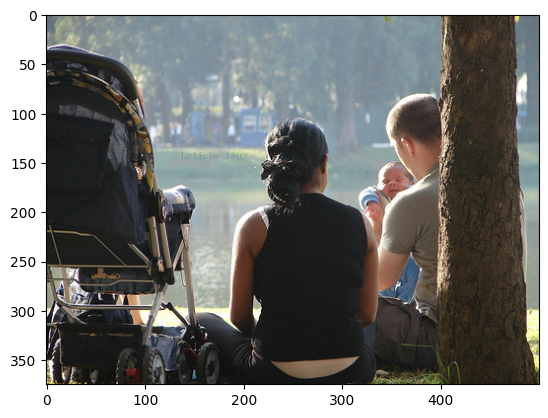

In [42]:
generate_caption("1022454428_b6b660a67b.jpg")

---------------------Actual---------------------
startseq man is standing in front of skyscraper endseq
startseq man stands in front of skyscraper endseq
startseq man stands in front of very tall building endseq
startseq behind the man in red shirt stands large skyscraper endseq
startseq there is skyscraper in the distance with man walking in front of the camera endseq
--------------------Predicted--------------------
startseq man stands on the street endseq


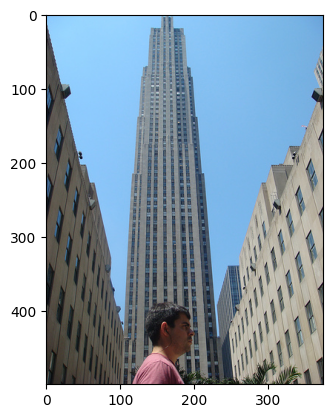

In [43]:
generate_caption("1032460886_4a598ed535.jpg")

---------------------Actual---------------------
startseq man uses ice picks and crampons to scale ice endseq
startseq an ice climber in blue jacket and black pants is scaling frozen ice wall endseq
startseq an ice climber scaling frozen waterfall endseq
startseq person in blue and red ice climbing with two picks endseq
startseq climber climbing an ice wall endseq
--------------------Predicted--------------------
startseq man in black and black jacket is scaling frozen ice skates endseq


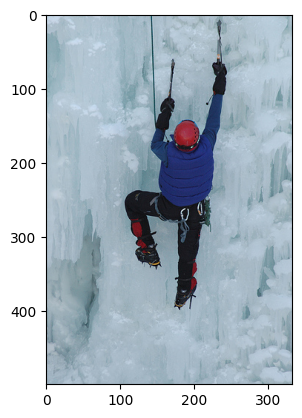

In [44]:
generate_caption("102455176_5f8ead62d5.jpg")

---------------------Actual---------------------
startseq person eats takeout while watching small television endseq
startseq person sits on the floor and eats in front of television endseq
startseq television with picture of girl on it endseq
startseq young man sits on the floor by the television with fast food meal in front of him endseq
startseq someone is laying in front of the tv eating food endseq
--------------------Predicted--------------------
startseq man eats takeout while watching television endseq


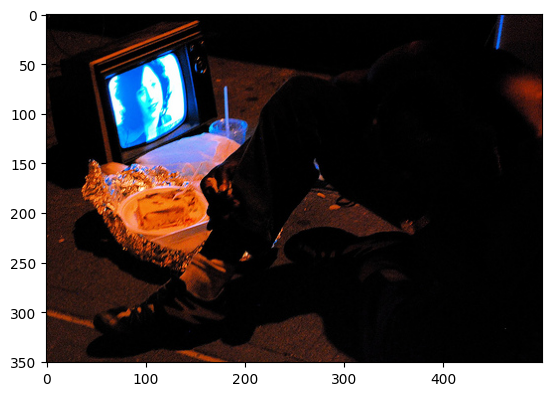

In [46]:
generate_caption("1045521051_108ebc19be.jpg")

---------------------Actual---------------------
startseq boy in blue shorts slides down slide into pool endseq
startseq boy in blue swimming trunks slides down yellow slide into wading pool with inflatable toys floating in the water endseq
startseq boy rides down slide into small backyard pool endseq
startseq boy sliding down slide into pool with colorful tubes endseq
startseq child is falling off slide onto colored balloons floating on pool of water endseq
--------------------Predicted--------------------
startseq little boy in green trunks and blue swimsuit is jumping into swimming pool endseq


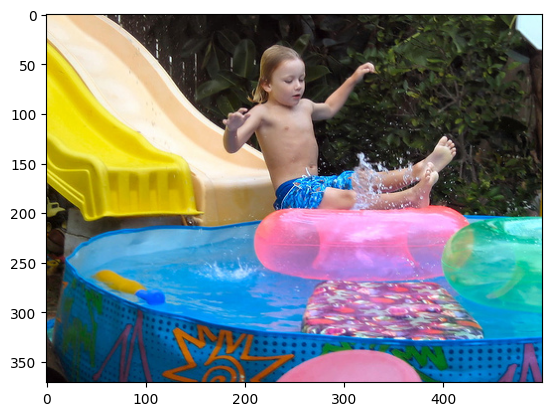

In [47]:
generate_caption("1077546505_a4f6c4daa9.jpg")

## Testing with New Images

In [34]:
import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

def new_caption(image_path, model, tokenizer, max_length):
    """
    Generates a caption for an image using a trained image captioning model.

    Args:
        image_path (str): Path to the image file.
        model: The trained image captioning model.
        tokenizer: The tokenizer used to encode text for the model.
        max_length: The maximum length of the generated caption.

    Returns:
        str: The generated caption.
    """

    # Load VGG16 model and restructure it to output features from the second-to-last layer
    vgg_model = VGG16()
    vgg_model = keras.models.Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

    # Display the image
    img = load_img(image_path)
    plt.imshow(img)

    # Load and preprocess the image
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Extract features from the image using VGG16
    feature = vgg_model.predict(image, verbose=0)

    # Generate caption using the trained model
    caption = predict_caption(model, feature, tokenizer, max_length)

    return caption


'startseq man climbing rock wall endseq'

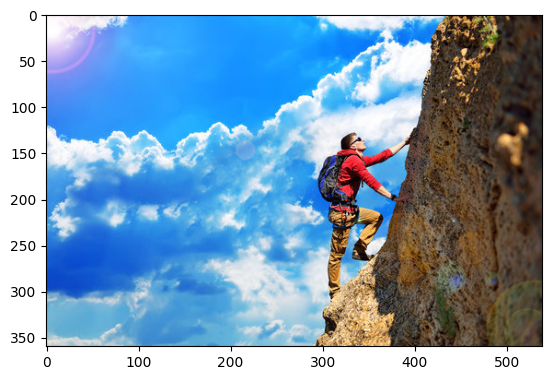

In [48]:
new_caption("/kaggle/input/image-caption-test-v2-0/hill_climb.jpg",model,tokenizer,max_length)

'startseq two women in heavy outfits are jumping on blue mat in front of tall tall grass endseq'

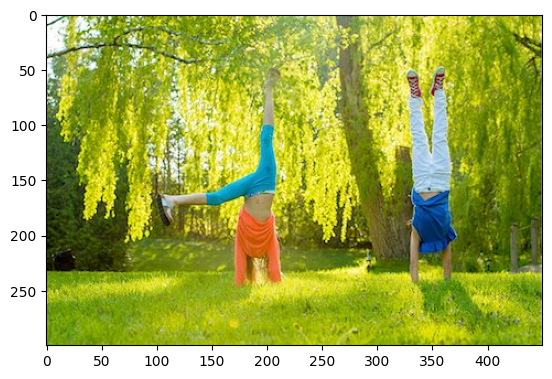

In [50]:
new_caption("/kaggle/input/image-caption-test-v2-0/handstand.jpg",model,tokenizer,max_length)

'startseq dog running through the grass endseq'

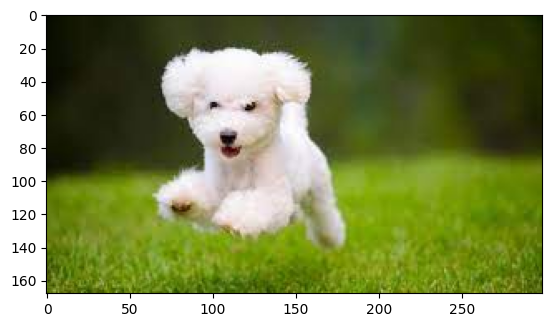

In [51]:
new_caption("/kaggle/input/image-caption-test-v2-0/dog1.jpg",model,tokenizer,max_length)